In [1]:
import sys
sys.path.append("..")
sys.path.append("../sac_ae")
print(sys.path)

['/home/ws/upecj/SafeTransferLearningInChangingEnvironments/src/notebooks', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/ws/upecj/SafeTransferLearningInChangingEnvironments/venv/lib/python3.8/site-packages', '/home/ws/upecj/SafeTransferLearningInChangingEnvironments/src/custom_envs', '/home/ws/upecj/SafeTransferLearningInChangingEnvironments/venv/lib/python3.8/site-packages/IPython/extensions', '/home/ws/upecj/.ipython', '..', '../sac_ae']


In [2]:
import gym
import custom_robotics
import wrappers
import numpy as np
from collections import namedtuple
import torch
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
from sac_ae.env import make_envs
from sac_ae.model import make_model
from sac_ae.agent import make_agent
from memory import ReplayBufferStorage, make_replay_buffer
from utils.misc import eval_mode

In [4]:
Args = namedtuple("Args", ["env_name", "seed", "pr_files", "env_image_size", "robot_shape", "frame_stack", "agent_image_size", #env
                           "agent", "hidden_dim", "encoder_feature_dim", "actor_log_std_min", "actor_log_std_max", "num_layers", "num_filters", #model
                          "sacae_update_freq", "sacae_encoder_tau", "sacae_autoencoder_lr", "sacae_autoencoder_beta", #sac ae
                          "actor_update_freq", "critic_target_update_freq", "critic_tau", "critic_encoder_tau", "log_interval", "discount", "detach_encoder", #sac
                          "init_temperature", "actor_lr", "actor_beta", "critic_lr", "critic_beta", "alpha_lr", "alpha_beta"]) #sac
args = Args("CustomFetchReachDense-v0", 1, None, 84, 10, 3, 84,
           "sacae", 1024, 50, -10, 2, 4, 32,
           1, 0.05, 1e-5, 0.9,
           2, 2, 0.01, 0.05, 25, 0.99, False,
           0.1, 1e-5, 0.9, 1e-5, 0.9, 1e-4, 0.5)

In [5]:
env = make_envs(args)

In [6]:
action_shape = env.action_space.shape
agent_obs_shape = (3*args.frame_stack, args.agent_image_size, args.agent_image_size)
env_obs_shape = (3*args.frame_stack, args.env_image_size, args.env_image_size)
device = "cpu"

In [7]:
model = make_model(agent_obs_shape, action_shape, args, device)

In [8]:
agent = make_agent(model, device, action_shape, args)

In [9]:
agent.load_model("../sac_ae/log/CustomFetchReachDense-v0-05-30-08-57-im84-b128-s1-sacae/model/250000.pt")

In [89]:
replay_storage = ReplayBufferStorage(Path("buffer") / "buffer", robot=args.robot_shape > 0)
replay_buffer = make_replay_buffer(replay_dir=Path("buffer") / "buffer",
                                                   max_size=10000,
                                                   batch_size=128,
                                                   num_workers=1,
                                                   save_snapshot=False,
                                                   nstep=1,
                                                   discount=args.discount,
                                                   obs_shape=env_obs_shape,
                                                   device=device,
                                                   image_size=args.agent_image_size,
                                                   image_pad=4,
                                                   robot=args.robot_shape > 0)

In [90]:
episode, episode_reward, done, info = 0, 0, True, {}

for step in range(101):
        if done:
            if step > 0:
                replay_storage.add(obs, None, None, True)  # add the last observation for each episode
                print("Episode: " + str(episode) + " Reward: " + str(episode_reward))

            obs = env.reset()
            done = False
            episode_reward = 0
            episode_step = 0
            episode += 1

        # sample action for data collection
        with eval_mode(agent):
            action = agent.sample_action(obs)
        next_obs, reward, done, info = env.step(action)

        # allow infinit bootstrap
        done_bool = 0 if episode_step + 1 == env._max_episode_steps else float(done)
        episode_reward += reward
        replay_storage.add(obs, action, reward, done_bool)    

        obs = next_obs
        episode_step += 1

Episode: 1 Reward: -6.704657050755615
Episode: 2 Reward: -11.458287316718183


In [91]:
replay_buffer.sample()

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ws/upecj/SafeTransferLearningInChangingEnvironments/venv/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ws/upecj/SafeTransferLearningInChangingEnvironments/venv/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 32, in fetch
    data.append(next(self.dataset_iter))
  File "/home/ws/upecj/SafeTransferLearningInChangingEnvironments/src/notebooks/../sac_ae/memory/replay_drq.py", line 173, in __iter__
    yield self._sample()
  File "/home/ws/upecj/SafeTransferLearningInChangingEnvironments/src/notebooks/../sac_ae/memory/replay_drq.py", line 157, in _sample
    episode = self._sample_episode()
  File "/home/ws/upecj/SafeTransferLearningInChangingEnvironments/src/notebooks/../sac_ae/memory/replay_drq.py", line 102, in _sample_episode
    eps_fn = random.choice(self._episode_fns)
  File "/usr/lib/python3.8/random.py", line 290, in choice
    raise IndexError('Cannot choose from an empty sequence') from None
IndexError: Cannot choose from an empty sequence


In [10]:
from sac_ae.memory.replay import ReplayBuffer

In [66]:
capacity = 10000
replay_buffer = ReplayBuffer(env_obs_shape, action_shape, capacity, 10000, device)
replay_buffer.obses = np.empty((capacity, *env_obs_shape), dtype=np.float32)
replay_buffer.next_obses = np.empty((capacity, *env_obs_shape), dtype=np.float32)

In [67]:
episode, episode_reward, done, info = 0, 0, True, {}

for step in range(10000):
        if done:
            obs = env.reset()
            done = False
            episode_reward = 0
            episode_step = 0
            episode += 1

        # sample action for data collection
        with eval_mode(agent):
            action = agent.sample_action(obs)
        next_obs, reward, done, info = env.step(action)

        # allow infinit bootstrap
        done_bool = 0 if episode_step + 1 == env._max_episode_steps else float(done)
        episode_reward += reward
        replay_buffer.add(obs["image"], action, reward, next_obs["image"], done_bool)    

        obs = next_obs
        episode_step += 1
        if done:
            print("Episode: " + str(episode) + " Reward: " + str(episode_reward))

Episode: 1 Reward: -10.712310638229818
Episode: 2 Reward: -11.140585281671362
Episode: 3 Reward: -15.769273608507822
Episode: 4 Reward: -9.97056336115544
Episode: 5 Reward: -15.844706040225237
Episode: 6 Reward: -13.215531176897056
Episode: 7 Reward: -8.448090219578717
Episode: 8 Reward: -12.32797470175201
Episode: 9 Reward: -9.25373190144821
Episode: 10 Reward: -4.729780056352251
Episode: 11 Reward: -12.500495969633569
Episode: 12 Reward: -9.755076127992945
Episode: 13 Reward: -9.732059130883354
Episode: 14 Reward: -15.414675176538987
Episode: 15 Reward: -11.00677934225412
Episode: 16 Reward: -8.056709851448966
Episode: 17 Reward: -13.116843095948699
Episode: 18 Reward: -14.51219724770787
Episode: 19 Reward: -13.340358941717138
Episode: 20 Reward: -12.608770029804594
Episode: 21 Reward: -11.220705674999161
Episode: 22 Reward: -14.483496131139226
Episode: 23 Reward: -13.30303173400797
Episode: 24 Reward: -8.13112873220566
Episode: 25 Reward: -9.11453966386276
Episode: 26 Reward: -12.96

In [68]:
sample = replay_buffer.sample()
images = sample[0]

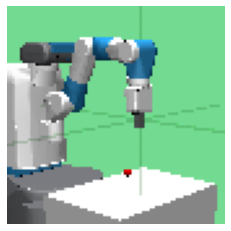

In [69]:
img = images[0,:3].numpy().transpose(1, 2, 0) / 255
plt.figure()
plt.axis('off')
plt.imshow(img)

In [70]:
latents = agent.model.autoencoder.encoder(images)
recreated = agent.model.autoencoder.decoder(latents)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


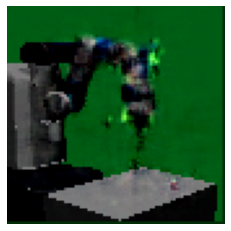

In [71]:
recreated = recreated[0, :3].detach().numpy().transpose(1, 2, 0)
plt.figure()
plt.axis('off')
plt.imshow(recreated)
plt.savefig('env_recreated.png')

In [73]:
from sklearn.decomposition import PCA

In [77]:
pca = PCA(n_components=2)
pca_res = pca.fit_transform(latents.detach().numpy())

In [96]:
import pandas as pd
import seaborn as sns

In [99]:
sns.set_theme()

In [97]:
df = pd.DataFrame(pca_res, columns=["x", "y"])

<AxesSubplot:xlabel='x', ylabel='y'>

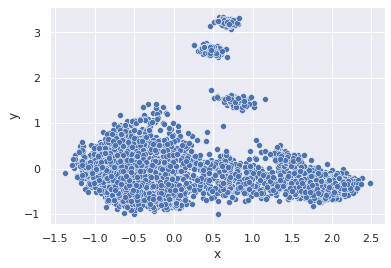

In [100]:
sns.scatterplot(data=df, x="x", y="y")

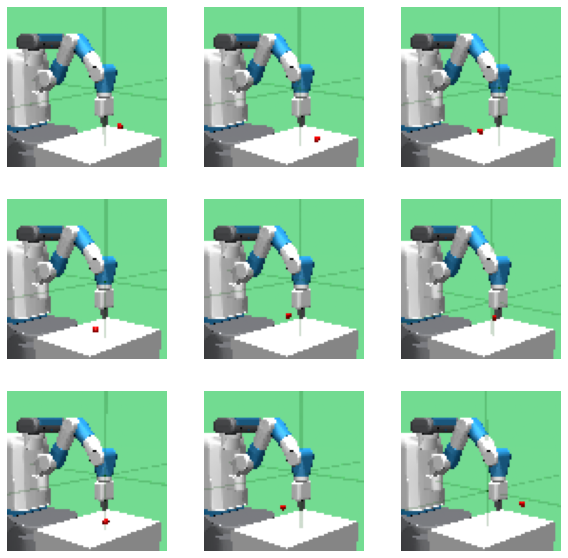

In [169]:
top_cluster = df[df["y"] > 3]
plt.figure(figsize=(10,10))
for i, idx in enumerate(top_cluster.index[:9]):
    img = images[idx,:3].numpy().transpose(1, 2, 0) / 255
    plt.subplot(3, 3, i + 1)
    plt.axis('off')
    plt.imshow(img)

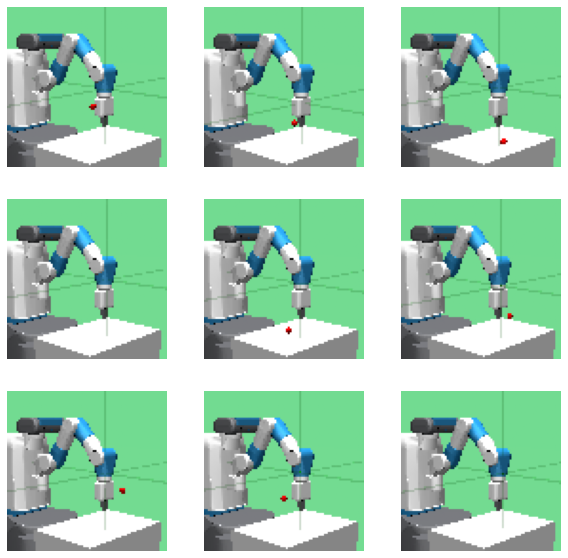

In [168]:
top_2nd_cluster = df[(df["y"] > 2) & (df["y"] < 3)]
plt.figure(figsize=(10,10))
for i, idx in enumerate(top_2nd_cluster.index[:9]):
    img = images[idx,:3].numpy().transpose(1, 2, 0) / 255
    plt.subplot(3, 3, i + 1)
    plt.axis('off')
    plt.imshow(img)

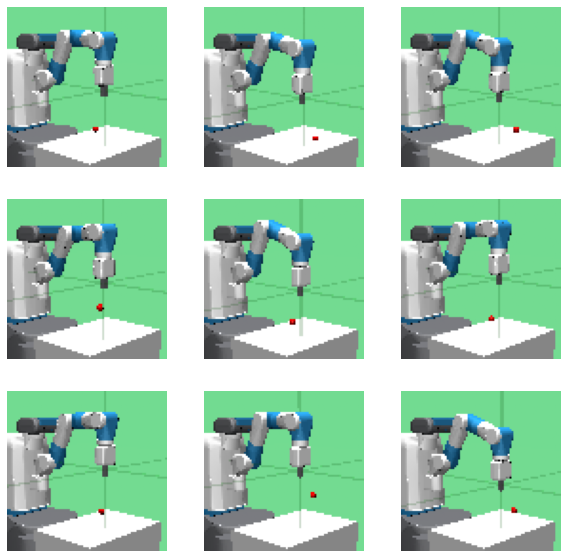

In [ ]:
left_cluster = df[df["x"] < 0]
plt.figure(figsize=(10,10))
for i, idx in enumerate(left_cluster.index[:9]):
    img = images[idx,:3].numpy().transpose(1, 2, 0) / 255
    plt.subplot(3, 3, i + 1)
    plt.axis('off')
    plt.imshow(img)

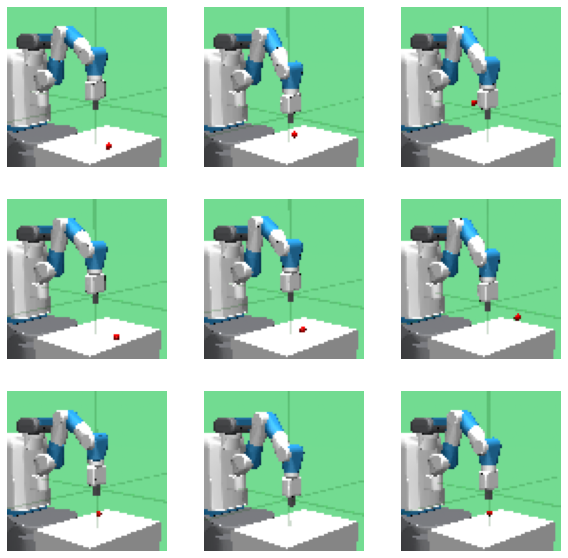

In [171]:
right_cluster = df[df["x"] > 1.5]
plt.figure(figsize=(10,10))
for i, idx in enumerate(right_cluster.index[:9]):
    img = images[idx,:3].numpy().transpose(1, 2, 0) / 255
    plt.subplot(3, 3, i + 1)
    plt.axis('off')
    plt.imshow(img)